In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
!ls "/content/gdrive/MyDrive/data"

Mounted at /content/gdrive
 face.csv	        faceLabel.csv
 faceData	        model4emotionClassfier
 faceData2D	        model4multiClassfier
 faceData2DWithNumber  'model4multiClassfier(exceptAge)'
 face_Dataset	        model4raceClassfier
 faceDataset	        model4sexClassfier
 faceDataset2	        model4sexClassfierWithoutValid
 faceDataWithNumber     rawdata
 faceDR		        rawdata.zip
 faceDS		        vgg_face_dag.pth


In [2]:
import matplotlib.pyplot as plt  # show image
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
dtype = np.uint8
shape = (128,128)

pre_img_path="/content/gdrive/MyDrive/data/rawdata/"
pre_path="/content/gdrive/MyDrive/data/"

In [5]:
!unzip "/content/gdrive/MyDrive/data/rawdata.zip" -d /content/sample_data/rawdataFolder

Archive:  /content/gdrive/MyDrive/data/rawdata.zip
   creating: /content/sample_data/rawdataFolder/rawdata/
  inflating: /content/sample_data/rawdataFolder/rawdata/1223  
  inflating: /content/sample_data/rawdataFolder/rawdata/1224  
  inflating: /content/sample_data/rawdataFolder/rawdata/1225  
  inflating: /content/sample_data/rawdataFolder/rawdata/1226  
  inflating: /content/sample_data/rawdataFolder/rawdata/1227  
  inflating: /content/sample_data/rawdataFolder/rawdata/1229  
  inflating: /content/sample_data/rawdataFolder/rawdata/1230  
  inflating: /content/sample_data/rawdataFolder/rawdata/1231  
  inflating: /content/sample_data/rawdataFolder/rawdata/1233  
  inflating: /content/sample_data/rawdataFolder/rawdata/1234  
  inflating: /content/sample_data/rawdataFolder/rawdata/1235  
  inflating: /content/sample_data/rawdataFolder/rawdata/1236  
  inflating: /content/sample_data/rawdataFolder/rawdata/1237  
  inflating: /content/sample_data/rawdataFolder/rawdata/1238  
  inflatin

In [6]:
pre_img_path="/content/sample_data/rawdataFolder/"

In [7]:
face=pd.read_csv(pre_path+"faceLabel.csv")

In [8]:


# read image part
new=True
for  i in face["number"]:
    if new==True:
        path=pre_img_path+f"rawdata/{i}"
        new_element = np.fromfile(path, dtype=dtype).reshape(shape)
        dataset = tf.data.Dataset.from_tensor_slices([new_element])
        new=False
    else:
        path=pre_img_path+f"rawdata/{i}"
        data = np.fromfile(path, dtype=dtype).reshape(shape)
        new_element = tf.data.Dataset.from_tensor_slices([data])
        dataset = dataset.concatenate(new_element)
print(dataset)


<_ConcatenateDataset element_spec=TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None)>


In [9]:
face.head()

,number,sex,age,race,emotion,extra,sex_label,age_adult,age_child,age_senior,...,race_black,race_hispanic,race_other,race_white,emotion_funny,emotion_serious,emotion_smiling,race_label,emotion_label,age_label
0,1223,male,child,white,smiling,NaN,1,0,1,0,...,0,0,0,1,0,0,1,4,2,1
1,1224,male,child,white,serious,NaN,1,0,1,0,...,0,0,0,1,0,1,0,4,1,1
2,1225,male,child,white,smiling,NaN,1,0,1,0,...,0,0,0,1,0,0,1,4,2,1
3,1226,male,child,white,smiling,NaN,1,0,1,0,...,0,0,0,1,0,0,1,4,2,1
4,1227,male,child,white,serious,NaN,1,0,1,0,...,0,0,0,1,0,1,0,4,1,1


In [10]:
def convert_image123(image):
    image = tf.expand_dims(image, axis=0)
    image = tf.expand_dims(image, axis=-1)
    return tf.tile(image, [1, 1, 1, 3])
dataset_ = dataset.map(convert_image123)

In [11]:
def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image
dataset_float = dataset_.map(convert_to_float)

In [12]:
num_elements = tf.data.experimental.cardinality(dataset_).numpy()
print(f"The dataset has {num_elements} elements.")

The dataset has 3993 elements.


In [13]:
# label2fit={'sex':["sex_label"],
#       'race':["race_asian","race_black","race_hispanic","race_other","race_white"],
#       'emotion':["emotion_funny","emotion_serious","emotion_smiling"],
#       'age':["age_adult","age_child","age_senior","age_teen"],
#       }
label2fit={
    'sex': ["sex_label"],
    'race': ["race_label"],
    'emotion': ["emotion_label"],
    'age': ["age_label"]
}

In [14]:
race_classes={0:"race_asian",1:"race_black",2:"race_hispanic",3:"race_other",4:"race_white"}
emotion_classes = {0: "emotion_funny", 1: "emotion_serious", 2: "emotion_smiling"}
age_classes = {0: "age_adult", 1: "age_child", 2: "age_senior", 3: "age_teen"}
sex_classes={0:'male',1:"female"}

In [15]:
num_classes={"race":5,"emotion":3,"age":4,"sex":2}

In [16]:
race_tensor=tf.convert_to_tensor(face[label2fit['race']].values)
emotion_tensor=tf.convert_to_tensor(face[label2fit['emotion']].values)
age_tensor=tf.convert_to_tensor(face[label2fit['age']].values)
sex_tensor=tf.convert_to_tensor(face[label2fit['sex']].values)

In [17]:
label_tensor={"race":race_tensor,"emotion":emotion_tensor,"age":age_tensor,"sex":sex_tensor}

In [18]:
# 首先，创建一个只包含 label_tensor 的数据集
label_dataset = tf.data.Dataset.from_tensor_slices((label_tensor['sex'], label_tensor['race'], label_tensor['emotion'], label_tensor['age']))

# 然后，使用 tf.data.Dataset.zip 方法将 dataset_float 和 label_dataset 合并
dataset = tf.data.Dataset.zip((dataset_float, label_dataset))

# 最后，使用 tf.data.Dataset.map 方法将每个元素转换为所需的形式
def map_fn(x, labels):
    return (x, *labels)

dataset = dataset.map(map_fn)

In [19]:
print(dataset)

<_MapDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [20]:
# split train and test sets
# 计算训练集大小（例如，80% 的数据用于训练）
train_size = int(num_elements * 0.85)

# 使用 take 方法获取训练集
ds_train = dataset.take(train_size)

# 使用 skip 方法获取测试集
ds_valid = dataset.skip(train_size)

In [21]:
print(ds_valid)

<_SkipDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [23]:
print(ds_valid)

<_PrefetchDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [24]:
def map_fn(image, sex, race, emotion, age):
    return image, {'sex_output': sex, 'race_output': race, 'emotion_output': emotion, 'age_output': age}
train_dataset = ds_train.map(map_fn)
valid_dataset = ds_valid.map(map_fn)

In [25]:
print(train_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), {'sex_output': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'race_output': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'emotion_output': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'age_output': TensorSpec(shape=(1,), dtype=tf.int64, name=None)})>


# 1) Define Pretrained Base #

Now that you have a pretrained base to do our feature extraction, decide whether this base should be trainable or not.

In [26]:
import tensorflow_hub as hub

# 3) Train #


In [27]:
pretrained_base = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/5")

f1_score

In [28]:
from keras import backend as K

def f1_score(y_true, y_pred):
    # Calculate the true positives, false positives, and false negatives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_score

ConfusionMatrix

In [29]:
from tensorflow.keras.metrics import Metric

class ConfusionMatrix(Metric):
    def __init__(self, num_classes, name='confusion_matrix', **kwargs):
        super(ConfusionMatrix, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_cm = self.add_weight(name='total_cm', shape=(num_classes, num_classes), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        current_cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, weights=sample_weight)
        return self.total_cm.assign_add(current_cm)

    def result(self):
        return self.total_cm

    def reset_states(self):
        self.total_cm.assign(tf.zeros((self.num_classes, self.num_classes)))

In [30]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
# from tensorflow.keras.layers.advanced_activations import LeakyReLU

feature_extractor=keras.Sequential([
  layers.Conv2D(filters=32,kernel_size=(5,5),strides=1,padding="valid",input_shape=(128,128,3)),
  layers.MaxPooling2D(pool_size=(3,3),strides=2),
  layers.Conv2D(filters=64,kernel_size=(4,4),strides=1,padding="same"),
  layers.MaxPooling2D(pool_size=(3,3),strides=2),
  layers.Conv2D(filters=128,kernel_size=(5,5),strides=1,padding="valid"),
  layers.MaxPooling2D(pool_size=(3,3),strides=2),
  layers.Flatten(),
])

input = Input(shape=(128, 128, 3))

# x = feature_extractor(input)
x = pretrained_base(input)

# x = Dense(2048,activation="tanh")(x)
# x = Dropout(0.3)(x)
# x = Dense(1024,activation="relu")(x)
# x = Dropout(0.3)(x)

x_sex= Dense(500,activation="tanh")(x)
sex_output = Dense(1, activation='sigmoid', name='sex_output')(x_sex)

x_emotion= Dense(500,activation="tanh")(x)
emotion_output = Dense(num_classes["emotion"], activation='softmax', name='emotion_output')(x_emotion)

x_race= Dense(500,activation="tanh")(x)
race_output= Dense(num_classes["race"],activation='softmax',name='race_output')(x_race)

x_age= Dense(500,activation="tanh")(x)
age_output= Dense(num_classes["age"],activation='softmax',name='age_output')(x_age)

model=Model(inputs=input,outputs=[sex_output,emotion_output,race_output,age_output])

In [31]:
model.compile(optimizer='adam',
              loss={'sex_output': 'binary_crossentropy', 'emotion_output': 'sparse_categorical_crossentropy','race_output':'sparse_categorical_crossentropy','age_output':'sparse_categorical_crossentropy'},
              metrics=[f1_score])


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint('model-{epoch:02d}.h5', save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

In [ ]:
# history = model.fit(    image_train,
#               {'sex_output': sex_train, 'emotion_output': emotion_train,'race_output':race_train,'age_output':age_train},
#               validation_data=(image_valid, {'sex_output': sex_valid, 'emotion_output': emotion_valid,'race_output':race_valid,'age_output':age_valid}),
#               callbacks=[checkpoint,early_stopping],
#               # metrics=["accuracy",f1_score],
#               epochs=10)
history = model.fit(train_dataset, validation_data=valid_dataset, callbacks=[checkpoint, early_stopping],epochs=100)

Epoch 1/100
3394/3394 [==============================] - 245s 70ms/step - loss: 2.6489 - sex_output_loss: 0.6277 - emotion_output_loss: 0.9347 - race_output_loss: 0.6251 - age_output_loss: 0.4613 - sex_output_f1_score: 0.5321 - emotion_output_f1_score: 0.4751 - race_output_f1_score: 0.2900 - age_output_f1_score: 0.0842 - val_loss: 21.6698 - val_sex_output_loss: 1.1932 - val_emotion_output_loss: 1.2761 - val_race_output_loss: 0.7255 - val_age_output_loss: 18.4750 - val_sex_output_f1_score: 0.6427 - val_emotion_output_f1_score: 0.4427 - val_race_output_f1_score: 0.2809 - val_age_output_f1_score: 0.0454
Epoch 2/100
1304/3394 [==========>...................] - ETA: 1:50 - loss: 2.0170 - sex_output_loss: 0.3853 - emotion_output_loss: 0.9428 - race_output_loss: 0.2296 - age_output_loss: 0.4592 - sex_output_f1_score: 0.6672 - emotion_output_f1_score: 0.4750 - race_output_f1_score: 0.2816 - age_output_f1_score: 0.1520

In [ ]:
# model.build()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1001)         6633209     ['input_8[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 2048)         2052096     ['keras_layer[3][0]']            
                                                                                                  
 dropout_8 (Dropout)            (None, 2048)         0           ['dense_8[0][0]']          

Run the cell below to plot the loss and metric curves for this training run.

Best val_loss: 2.741617441177368


<Axes: >

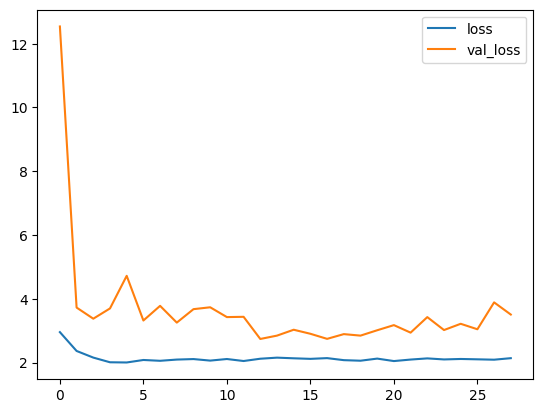

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
# best_accuracy = max(history.history['accuracy'])
# print('Best accuracy:', best_accuracy)
# best_val_accuracy = max(history.history['val_accuracy'])
# print('Best val_accuracy:', best_val_accuracy)
best_val_loss = min(history.history['val_loss'])
print('Best val_loss:', best_val_loss)
history_frame.loc[:, ['loss', 'val_loss']].plot()
# history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
# history_frame.loc[:, ['f1_score','val_f1_score']].plot()

ConfusionMatrix查看分类效果

In [ ]:
def split_features_labels(features, labels):
    return features, labels

x_valid = ds_valid.map(lambda features, *labels: features)
y_valid = ds_valid.map(lambda features, *labels: labels)

In [ ]:
print(x_valid)

<_MapDataset element_spec=TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None)>


In [ ]:
# 预测测试数据的标签
y_pred = model.predict(x_valid)
# y_pred_classes = tf.argmax(y_pred, axis=-1)
# y_true = np.concatenate([y for x, y in ds_valid], axis=0)
# y_valid_classes = tf.argmax(y_true, axis=-1)

599/599 [==============================] - 7s 6ms/step


In [ ]:
# print(y_valid_classes)
print(y_pred[1])

[[0.02834759 0.5103539  0.46129847]
 [0.02834759 0.5103539  0.46129847]
 [0.02834759 0.5103539  0.46129847]
 ...
 [0.02834759 0.5103539  0.46129847]
 [0.02834759 0.5103539  0.46129847]
 [0.02834759 0.5103539  0.46129847]]


In [ ]:
# 计算混淆矩阵
cm = tf.math.confusion_matrix(y_valid_classes, y_pred_classes, num_classes=4)
print(cm)

tf.Tensor(
[[799   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]], shape=(4, 4), dtype=int32)


In [ ]:
for layer in model.layers:
  if isinstance(layer,layers.Dense):
    print((layer.get_weights()))
    break
    # print(layer)


[array([[-0.16068304, -0.02021801,  0.01220171, ...,  0.04972925,
        -0.01576226,  0.07770742],
       [-0.21458483, -0.01960546, -0.06700288, ...,  0.03656002,
        -0.06027891, -0.10255808],
       [-0.02031255, -0.07343941, -0.04651226, ..., -0.0613129 ,
        -0.1902814 , -0.06642091],
       ...,
       [-0.08625404, -0.03248319, -0.09819345, ..., -0.02663578,
        -0.09103512,  0.00201945],
       [-0.06470115,  0.02755245, -0.09048891, ...,  0.01507921,
         0.07729109, -0.0495067 ],
       [-0.05876072,  0.0109858 ,  0.06754052, ...,  0.11740114,
        -0.0622575 ,  0.02708601]], dtype=float32), array([-0.12533294, -0.20896395, -0.18393034, ..., -0.19678204,
       -0.13072017, -0.1819787 ], dtype=float32)]


In [ ]:
i=0
for e in ds_valid:
  # print(e[1])
  # print(e[0])
  # prediction=model.predict(e[0])
  # print(prediction)
  # print([1 if i>0.5 else 0 for i in l ])
  i+=1
  if i>520:
    print(e[1])
    # print(e[0])
    prediction=model.predict(e[0])
    print(prediction)
    break

tf.Tensor([[1]], shape=(1, 1), dtype=int64)
1/1 [==============================] - 0s 165ms/step
[[0.57720494]]


In [ ]:

print([1 if i>0.5 else 0 for i in prediction[0]])

[1]


In [ ]:
# # 定义输入和输出
# inputs = {'input_image': model.input}
# outputs = {'output_scores': model.output}

# 导出模型
# tf.saved_model.save(model, pre_path+"modelTPU4multiClassfier(exceptAge)")

In [ ]:
# model_load=tf.saved_model.load(pre_path+"model4multiClassfier")

In [ ]:
# print(model_load.signatures.keys())

In [ ]:
# model.predict(ds_valid_)

In [ ]:
# for e in ds_valid:
#   print(e[1])
#   # print(e[0])
#   prediction=model_load.signatures['serving_default'](e[0])
#   print(prediction)
#   # print([1 if i>0.5 else 0 for i in l ])
#   break

In [ ]:
# print(prediction['dense_9'].numpy())

In [ ]:
# print([1 if i>0.5 else 0 for i in prediction['dense_9'].numpy()[0]])